In [1]:
import math

import cufflinks as cf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from IPYNBrenderer import render_google_doc

cf.go_offline()
import warnings

warnings.filterwarnings('ignore')

2022-10-23 00:47:19.944433: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Batch normalization

### forward pass 
step 1
$$ \ μ_B = \frac{1}{m_B} \sum_{i=1}^{m_B} \ x^(i)

step2
$$ \ σ_B^2 = \frac{1}{m_B} \sum_{i=1}^{m_B} ( \ x^(i) - μ_B )^2


step 3
$$ \hat{x}^(i) =\frac{ x^(i) - μ_B}{\sqrt{σ_B^2+ \epsilon}}

step 4
$$ z^(i) = \gamma \cdot \hat{x}^(i) + \beta

In [2]:
class BatchNormalization:
    def __init__(self, gamma=1, beta=0, eps=1e-5):
        """ gamma: scale parameter beta: shift parameter eps: small value for numerical stability """
        self.gamma = gamma
        self.beta = beta
        self.eps = eps
        self.running_mean = 0
        self.running_var = 0
        self.batch_mean = 0
        self.batch_var = 0
        self.batch_size = 0
        self.x = 0
        self.x_norm = 0

    def forward(self, x, is_training=True):
        self.batch_size = x.shape[0]
        self.x = x
        if is_training:
            self.batch_mean =  np.mean(x, axis=0)
            self.batch_var =  np.var(x, axis=0)
            self.running_mean = 0.9 * self.running_mean + 0.1 * self.batch_mean
            self.running_var = 0.9 * self.running_var + 0.1 * self.batch_var
        else:
            self.batch_mean = self.running_mean
            self.batch_var = self.running_var
        self.x_norm = (x - self.batch_mean) / np.sqrt(self.batch_var + self.eps)
        out = self.gamma * self.x_norm + self.beta
        return out

    def backward(self, dout):
        dbeta = np.sum(dout, axis=0)
        dgamma = np.sum(self.x_norm * dout, axis=0)
        dx_norm = dout * self.gamma
        dx = (1. / self.batch_size) * (self.batch_size * dx_norm - np.sum(dx_norm, axis=0) - self.x_norm * np.sum(dx_norm * self.x_norm, axis=0))
        return dx, dgamma, dbeta


In [3]:
X = np.random.random((1000, 100)) # 1000 data points, each with dimension 100

In [4]:

model = BatchNormalization()
dout = model.forward(X , is_training=True)

In [5]:
model.__dict__

{'gamma': 1,
 'beta': 0,
 'eps': 1e-05,
 'running_mean': array([0.05178427, 0.04964296, 0.05070154, 0.04921042, 0.05087484,
        0.05087311, 0.04945032, 0.0505977 , 0.05011531, 0.05060157,
        0.04962816, 0.04869402, 0.04962137, 0.05116433, 0.04927181,
        0.04986094, 0.04967575, 0.05027837, 0.04952978, 0.04918823,
        0.05027932, 0.04928979, 0.0515596 , 0.0504087 , 0.05085139,
        0.04965618, 0.04763013, 0.05154271, 0.05012575, 0.05132766,
        0.05161985, 0.04981221, 0.05130008, 0.05067616, 0.05027055,
        0.05080294, 0.05077977, 0.05047976, 0.04801979, 0.05045796,
        0.04932913, 0.04975918, 0.04939003, 0.05119813, 0.04922982,
        0.04920437, 0.05145228, 0.05084441, 0.04996796, 0.05072907,
        0.048713  , 0.04876115, 0.04968213, 0.05043019, 0.05023057,
        0.04835102, 0.0519194 , 0.05027494, 0.05018238, 0.04932045,
        0.05166687, 0.0501641 , 0.05042503, 0.05090399, 0.04995153,
        0.04897236, 0.05036388, 0.05109891, 0.04929343, 0.04

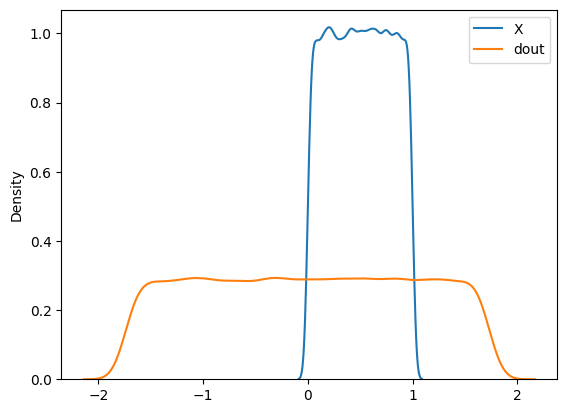

In [6]:
sns.distplot(X, label='X' , hist=False)
sns.distplot(dout, label='dout' , hist=False)
plt.legend( loc='upper right')

In [7]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full
X_test = X_test 
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]


In [8]:
tf.random.set_seed(42)
np.random.seed(42)

LAYERS = [ tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal"),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal"),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dense(10, activation="softmax")]


model = tf.keras.models.Sequential(LAYERS)

In [9]:
import time
import os

def get_log_dir():
    root_logdir = os.path.join(os.curdir, "my_logs")
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    tensor_path = os.path.join(root_logdir, run_id)
    os.makedirs(tensor_path , exist_ok=True)
    return tensor_path

In [10]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(get_log_dir())

In [11]:

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

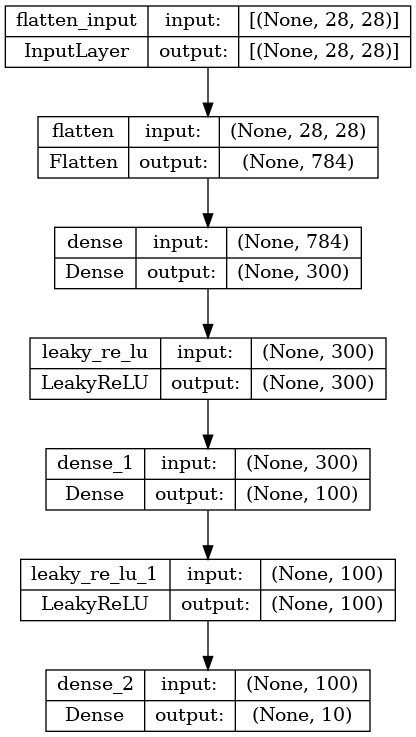

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trai

In [14]:
%%time
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb , tensorboard_cb])

Epoch 1/30
1719/1719 [==============================] - 6s 3ms/step - loss: nan - accuracy: 0.1007 - val_loss: nan - val_accuracy: 0.0914
Epoch 2/30
1719/1719 [==============================] - 6s 4ms/step - loss: nan - accuracy: 0.1008 - val_loss: nan - val_accuracy: 0.0914
Epoch 3/30
1719/1719 [==============================] - 16s 9ms/step - loss: nan - accuracy: 0.1008 - val_loss: nan - val_accuracy: 0.0914
Epoch 4/30
1719/1719 [==============================] - 10s 6ms/step - loss: nan - accuracy: 0.1008 - val_loss: nan - val_accuracy: 0.0914
Epoch 5/30
1719/1719 [==============================] - 17s 10ms/step - loss: nan - accuracy: 0.1008 - val_loss: nan - val_accuracy: 0.0914
CPU times: user 1min 22s, sys: 10.6 s, total: 1min 33s
Wall time: 56.4 s


In [20]:
LAYERS = [ tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal"),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal"),
    tf.keras.layers.LeakyReLU(),
    
    tf.keras.layers.Dense(10, activation="softmax")]
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2,mode="min" ,monitor='val_loss',restore_best_weights=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(get_log_dir())

model_batch = tf.keras.models.Sequential(LAYERS)

In [22]:
model_batch.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"] )

In [23]:
%%timeit
model_batch.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb , tensorboard_cb])

Epoch 1/30
1719/1719 [==============================] - 10s 5ms/step - loss: 0.8755 - accuracy: 0.7071 - val_loss: 0.5982 - val_accuracy: 0.7964
Epoch 2/30
1719/1719 [==============================] - 11s 7ms/step - loss: 0.5990 - accuracy: 0.7908 - val_loss: 0.5327 - val_accuracy: 0.8230
Epoch 3/30
1719/1719 [==============================] - 19s 11ms/step - loss: 0.5453 - accuracy: 0.8091 - val_loss: 0.5382 - val_accuracy: 0.8336
Epoch 4/30
1719/1719 [==============================] - 25s 14ms/step - loss: 0.5105 - accuracy: 0.8199 - val_loss: 0.5018 - val_accuracy: 0.8412
Epoch 5/30
1719/1719 [==============================] - 27s 16ms/step - loss: 0.4888 - accuracy: 0.8253 - val_loss: 0.4531 - val_accuracy: 0.8486
Epoch 6/30
1719/1719 [==============================] - 25s 14ms/step - loss: 0.4727 - accuracy: 0.8325 - val_loss: 0.4510 - val_accuracy: 0.8506
Epoch 7/30
1719/1719 [==============================] - 26s 15ms/step - loss: 0.4596 - accuracy: 0.8363 - val_loss: 0.4348 - v

#### we didnt normalize the inputs  the  model with batch normalization gives accurracy  87 vs 10 for without  

#### with batch initialization we get a val loss 0.603 in the initial epochs .a after 30 epochs 0.35

# lets normalize the input data

In [ ]:
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [24]:
%%timeit
tf.random.set_seed(42)
np.random.seed(42)

LAYERS = [ tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation='selu' , kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation='selu' , kernel_initializer="he_normal"),
    tf.keras.layers.Dense(10, activation="softmax")]


model_normalized = tf.keras.models.Sequential(LAYERS)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2,mode="min" ,monitor='val_loss',restore_best_weights=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(get_log_dir())
model_normalized.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(lr=1e-3), metrics=["accuracy"])
model_normalized.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])


Epoch 1/30
1719/1719 [==============================] - 4s 2ms/step - loss: 6.4354 - accuracy: 0.6244 - val_loss: 1.0608 - val_accuracy: 0.6678
Epoch 2/30
1719/1719 [==============================] - 14s 8ms/step - loss: 0.8755 - accuracy: 0.6866 - val_loss: 0.8416 - val_accuracy: 0.7160
Epoch 3/30
1719/1719 [==============================] - 18s 10ms/step - loss: 0.7546 - accuracy: 0.7062 - val_loss: 0.7898 - val_accuracy: 0.6996
Epoch 4/30
1719/1719 [==============================] - 19s 11ms/step - loss: 0.7063 - accuracy: 0.7158 - val_loss: 0.7285 - val_accuracy: 0.7018
Epoch 5/30
1719/1719 [==============================] - 11s 6ms/step - loss: 0.6700 - accuracy: 0.7241 - val_loss: 0.7010 - val_accuracy: 0.7384
Epoch 6/30
1719/1719 [==============================] - 12s 7ms/step - loss: 0.6443 - accuracy: 0.7296 - val_loss: 0.6932 - val_accuracy: 0.7460
Epoch 7/30
1719/1719 [==============================] - 11s 6ms/step - loss: 0.6266 - accuracy: 0.7337 - val_loss: 0.6795 - val_a

In [25]:
%%timeit
LAYERS = [ tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal"),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal"),
    tf.keras.layers.LeakyReLU(),
    
    tf.keras.layers.Dense(10, activation="softmax")]
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2,mode="min" ,monitor='val_loss',restore_best_weights=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(get_log_dir())
model_normalized_batch= tf.keras.models.Sequential(LAYERS)
model_normalized_batch.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(lr=1e-3), metrics=["accuracy"])
history = model_normalized_batch.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])

Epoch 1/30
1719/1719 [==============================] - 11s 6ms/step - loss: 0.8767 - accuracy: 0.7045 - val_loss: 0.5995 - val_accuracy: 0.7942
Epoch 2/30
1719/1719 [==============================] - 24s 14ms/step - loss: 0.5902 - accuracy: 0.7928 - val_loss: 0.5337 - val_accuracy: 0.8228
Epoch 3/30
1719/1719 [==============================] - 15s 9ms/step - loss: 0.5355 - accuracy: 0.8126 - val_loss: 0.5286 - val_accuracy: 0.8354
Epoch 4/30
1719/1719 [==============================] - 26s 15ms/step - loss: 0.5010 - accuracy: 0.8242 - val_loss: 0.4991 - val_accuracy: 0.8412
Epoch 5/30
1719/1719 [==============================] - 26s 15ms/step - loss: 0.4795 - accuracy: 0.8315 - val_loss: 0.4504 - val_accuracy: 0.8492
Epoch 6/30
1719/1719 [==============================] - 25s 15ms/step - loss: 0.4649 - accuracy: 0.8371 - val_loss: 0.4454 - val_accuracy: 0.8520
Epoch 7/30
1719/1719 [==============================] - 24s 14ms/step - loss: 0.4526 - accuracy: 0.8416 - val_loss: 0.4294 - v

# understanding manually  the forward pass

In [26]:
# step 1 
X = np.random.random((100, 1))
df = pd.DataFrame(X, columns = ['X'])

In [27]:
df.iplot()

In [28]:
BATCH_MEAN = np.mean(X)
# STEP 2
BATCH_VAR = np.var(X)

In [29]:
BATCH_MEAN , BATCH_VAR

(0.47018074337820936, 0.08761495016957914)

In [30]:
EPSILON = 1e-8

In [31]:
# step 3

df['X_norm'] = (df['X'] - BATCH_MEAN) / math.sqrt(BATCH_VAR + EPSILON)

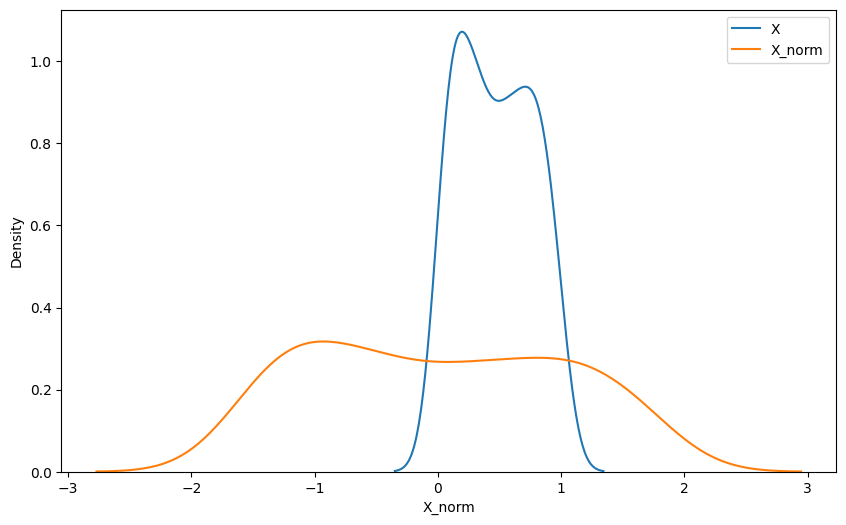

In [32]:
fig = plt.figure(figsize=(10,6))
sns.distplot(df["X"] , hist=False ,  label= "X")
sns.distplot(df["X_norm"] , hist=False , label= "X_norm")
plt.legend(labels = ['X', 'X_norm'])
plt.show()


In [33]:
df["gamma"] = 0.7 * df["X_norm"]

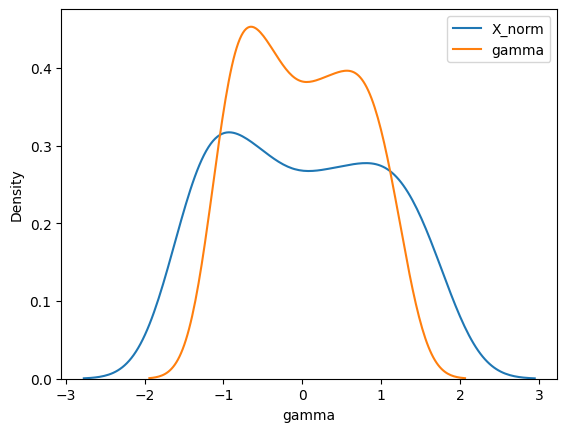

In [34]:
sns.distplot(df["X_norm"] , hist=False , label= "X_norm")
sns.distplot(df["gamma"] , hist=False , label= "gamma")
plt.legend(labels = ['X_norm', 'gamma'])

In [35]:
df["beta"] = 0.3 + df["gamma"]

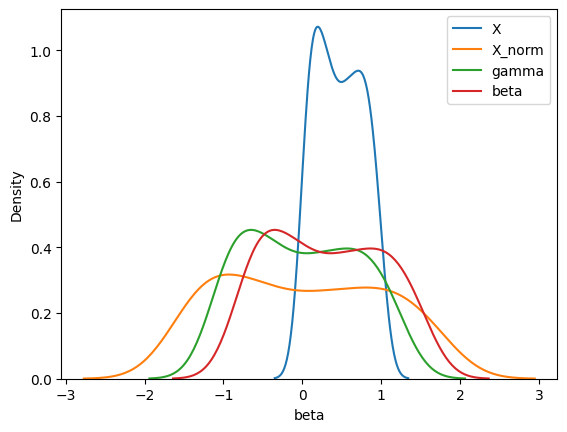

In [36]:
sns.distplot(df["X"] , hist=False , label= "gamma")
sns.distplot(df["X_norm"] , hist=False , label= "beta")
sns.distplot(df["gamma"] , hist=False , label= "gamma")
sns.distplot(df["beta"] , hist=False , label= "beta")
plt.legend(labels = ['X', 'X_norm', 'gamma', 'beta'])